# Demostrative example of how to use the TorchHub Interface

We provide a simple TorchHub Interface to access the KITTI 142 Split test data and the pretrained model on KITTI Depth Completion

In [19]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

### Reproducing the results on the KITTI 142 Split

In [18]:
def transform(d):
    for k in d:
        d[k] = F.to_tensor(d[k])
    d["img"] = F.normalize(d["img"], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return d

dl_split_142 = DataLoader(
    torch.hub.load("andreaconti/lidar-confidence", "dataset_kitti_142", transform=transform),
    num_workers=4,
)
model = torch.hub.load("andreaconti/lidar-confidence", "model")
cost_curve_aucs = torch.hub.load("andreaconti/lidar-confidence", "auc")

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.eval()

metrics = defaultdict(lambda: [])
with torch.no_grad():
    for batch in dl_split_142:
        img, lidar = batch["img"].to(device), batch["lidar"].to(device)
        gt = batch["gt"].to(device)
        std = model(torch.cat([img, lidar], 1))
        confs = std.max() - std
        auc_mae, *_ = cost_curve_aucs(gt, lidar, confs, "mae" )
        auc_rmse, *_ = cost_curve_aucs(gt, lidar, confs, "rmse")
        metrics["kitti_142/auc_mae"].append(auc_mae.cpu().item())
        metrics["kitti_142/auc_rmse"].append(auc_rmse.cpu().item())

print(f"AUC MAE 142 Split: {np.mean(metrics['kitti_142/auc_mae']):.5f}")
print(f"AUC RMSE 142 Split: {np.mean(metrics['kitti_142/auc_rmse']):.5f}")

AUC MAE 142 Split: 0.03759
AUC RMSE 142 Split: 0.19847


### Filtering a Depth Map

Following an example of how to filter a sparse depth map from the KITTI 142 Split

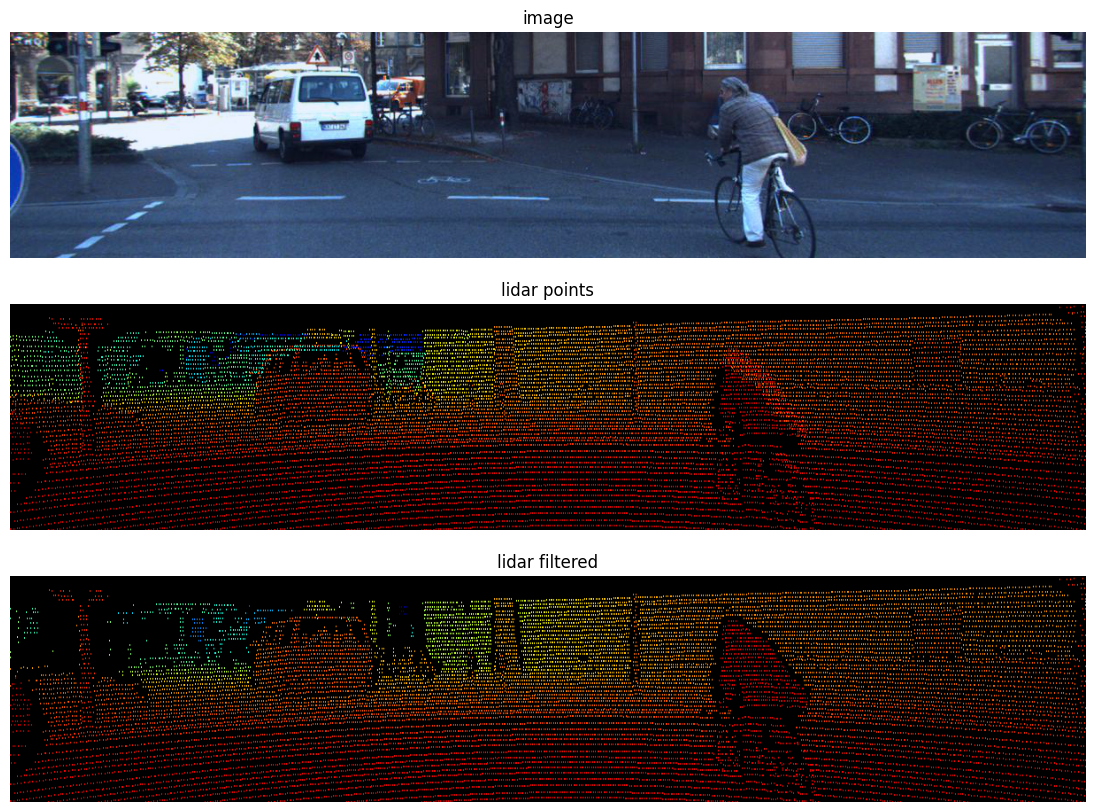

In [62]:
# Image to show
IMG_IDX = 0

# Percentage of points to keep
PERCENTILE = 90

def percentiles(x, percentiles):
    if not isinstance(percentiles, torch.Tensor):
        percentiles = torch.tensor(percentiles, dtype=x.dtype, device=x.device)

    x = x.view(x.shape[0], -1)
    in_sorted, in_argsort = torch.sort(x, dim=0)
    positions = percentiles * (x.shape[0] - 1) / 100
    floored = torch.floor(positions)
    ceiled = floored + 1
    ceiled[ceiled > x.shape[0] - 1] = x.shape[0] - 1
    weight_ceiled = positions - floored
    weight_floored = 1.0 - weight_ceiled
    d0 = in_sorted[floored.long(), :] * weight_floored[:, None]
    d1 = in_sorted[ceiled.long(), :] * weight_ceiled[:, None]
    result = (d0 + d1).view(-1, *x.shape[1:])
    return result.type(x.dtype)

dl_iter = iter(dl_split_142)
for i in range(IMG_IDX + 1):
    batch = next(dl_iter)
    
def depth_imshow(depth):
    depth = depth.clone()
    depth[depth > 0] = depth.max() - depth[depth > 0]
    plt.imshow(depth, cmap="inferno")

def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

import cv2
import cmapy

def color_map(x):
    x = x.cpu().numpy()
    x = cv2.dilate(x, (4, 4))
    x = (x - x.min()) / (x.max() - x.min())
    x = np.round(x * 255).astype(np.uint8)
    out = cmapy.colorize(x[..., None], "jet")
    out[x == 0] = 0.
    return out
    
mask = batch["lidar"] > 0
with torch.no_grad():
    std = model(torch.cat([batch["img"].to("cuda"), batch["lidar"].to("cuda")], 1)).cpu()
    percentile = percentiles(std[mask], [PERCENTILE])[0, 0]
    mask_ = mask & (std <= percentile)

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1); plt.axis("off"); plt.title("image"); plt.imshow(normalize(batch["img"])[0, : , 64:].permute(1, 2, 0))
plt.subplot(3, 1, 2); plt.axis("off"); plt.title("lidar points"); plt.imshow(color_map(batch["lidar"][0, 0, 64:]))
lidar_filtered = torch.where(mask_, batch["lidar"], torch.tensor(0.))
plt.subplot(3, 1, 3); plt.axis("off"); plt.title("lidar filtered"); plt.imshow(color_map(lidar_filtered[0, 0, 64:]))
plt.show()